<a href="https://colab.research.google.com/github/uss111kr/Land-Use-and-Land-Cover/blob/main/Uma_Shankar_Singh_Project_Land_Use_and_Land_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Land Use and Land Cover

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Land cover is the bio-physical material present on the Earth's surface. For example - water bodies, forests, bare soil, man-made surfaces.

Land use is the purpose or activity of the surface for human consumption. For example - agriculture, residential, commercial, conservation.

Land cover can be analysed for desired geographical region through satelite imagery. The trend of changed land cover can be used to understand the pattern of land use, and plan accordingly.

In this notebook, we will use simple clustering (K-Means) to identify land cover of Kathmandu valley (and outskirts) and calculate the "forest cover" percentage.

### Satellite Imagery Data

While a standard photo uses only Red, Green, and Blue channels, multi-spectral satellites like (Sentinel-2)[https://dataspace.copernicus.eu/data-collections/copernicus-sentinel-data/sentinel-2] capture "invisible" light across 12 distinct spectral bands. These extra bands, such as Infrared, allow us to detect "spectral signatures" that differentiate materials - like grass versus green paint.

For machine learning, we reshape this data into a matrix where each of the $H \times W$ pixels is a sample and each band is a feature. This high-dimensional depth enables algorithms like K-Means to group land covers with far greater precision than standard 3-band imagery.

Read more about the bands (here)[https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands].

### Reading the satellite image


In [ ]:
# use rasterio to load the satellite image properly
# https://rasterio.readthedocs.io/en/stable/
import rasterio

tiff_path = '/content/drive/MyDrive/Python/ktm2026-20260111T052627Z-3-001/ktm2026/merged.tiff'

# Reading the data as numpy ndarray
src = rasterio.open(tiff_path)

data = src.read()
src.close()

print(f'\nRead data as matrix of shape {data.shape}')


Read data as matrix of shape (12, 1987, 2500)


### Task 1: Reshape the data

In [ ]:
# the shape of data is (N, H, W) where:
N = 12
H = 1987
W = 2500

# reshape the data to (H x W, N)
# the data in a row should correspond to a pixel

# verify data for a random pixel
random_pixel = (118, 256) # (h, w)

display(data[:, random_pixel[0], random_pixel[1]])

data = data.transpose(1, 2, 0).reshape(H * W, N)

display(data[random_pixel[0] * W + random_pixel[1]])

array([0.0438, 0.0528, 0.0739, 0.0323, 0.1021, 0.1317, 0.1481, 0.156 ,
       0.1726, 0.195 , 0.2018, 0.1298], dtype=float32)

array([0.0438, 0.0528, 0.0739, 0.0323, 0.1021, 0.1317, 0.1481, 0.156 ,
       0.1726, 0.195 , 0.2018, 0.1298], dtype=float32)

### Task 2: Train the model

In [ ]:
# import Pipeline, KMeans and StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

from skimage import io
#  create a pipeline with StandardScaler and KMeans

# "normalize" the data before training
# create a pipeline and use the "fit" method to train the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clusters', KMeans(5))
]).fit(data)

### Task 3: Interpret the clusters

1. See the clusters and labels of the trianed model
2. Map each cluster to a color
3. Create an image data (matrix of shape $3 \times W \times H$) using the labels
4. See the image and interpret the meaning of each cluster


array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

array([[-0.2993132 , -0.37819406, -0.40836397, -0.21194674, -0.47930148,
        -0.57704526, -0.58494705, -0.60645074, -0.5993264 , -0.33254817,
        -0.67236304, -0.57343096],
       [11.65759   , 11.457213  , 10.771009  , 11.76966   , 11.176572  ,
        10.019802  ,  9.098197  ,  8.186053  ,  8.440502  , 10.598723  ,
         8.04369   ,  7.86737   ],
       [-0.29188645, -0.2603938 , -0.41059303, -0.25921062, -0.19526556,
         0.6065629 ,  0.7735335 ,  0.8273089 ,  0.83887964,  0.42937714,
        -0.19648091, -0.49466538],
       [ 0.22758378,  0.29786125,  0.4325434 ,  0.11245608,  0.3717224 ,
         0.0302835 , -0.03946602, -0.02923673, -0.04859135, -0.14872591,
         0.6351308 ,  0.711834  ],
       [ 4.8516846 ,  4.615395  ,  4.2293844 ,  5.0874186 ,  4.389338  ,
         3.987935  ,  3.6329994 ,  3.246903  ,  3.3509693 ,  4.988139  ,
         3.0500407 ,  2.927555  ]], dtype=float32)

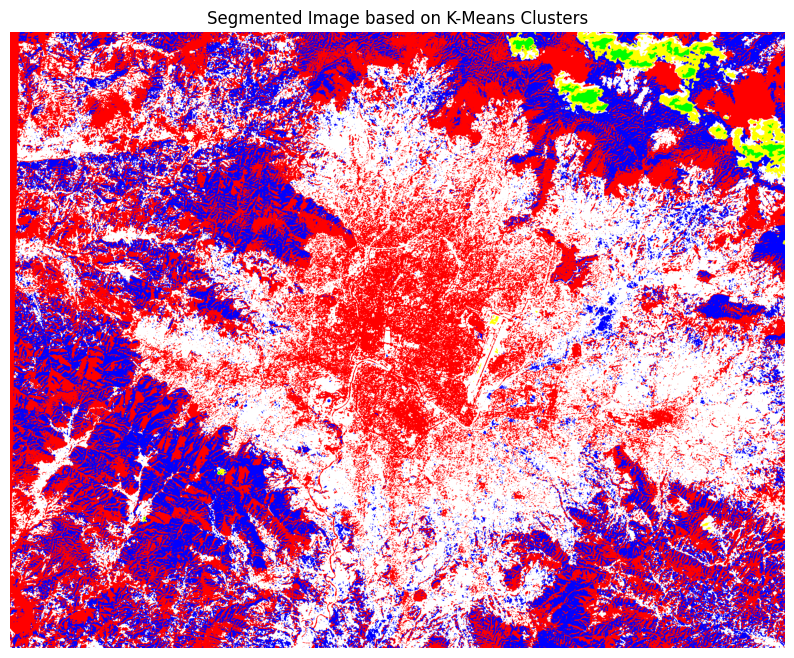

In [ ]:
# see the clusters and labels of the trained model
# plot the clusters by colors for each pixel
# visualize the map with colors

import numpy as np
import matplotlib.pyplot as plt

# see the centers and labels of the trained model (clusters)
clusters = pipeline.named_steps['clusters']

labels = clusters.labels_
centers = clusters.cluster_centers_

display(labels, centers)

# plot the clusters by colors for each pixel
colors = [
  [255, 0, 0], # Red
  [0, 255, 0], # Green
  [0, 0, 255], # Blue
  [255, 255, 255], # White
  [255, 255, 0] # Yellow
]

# Reshape labels to original image dimensions
labels_reshaped = labels.reshape(H, W)

# Create an empty image matrix and fill it with colors based on labels
segmented_image = np.zeros((H, W, 3), dtype=np.uint8)
for i in range(H):
  for j in range(W):
    segmented_image[i, j] = colors[labels_reshaped[i,j]]

# visualize the map with colors
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.title('Segmented Image based on K-Means Clusters')
plt.axis('off')
plt.show()

### Task 4: Calculate "cover percentage" for each cluster


In [ ]:
unique_elements, counts = np.unique(labels, return_counts = True)
# equivalent to pandas value_counts

total_count = np.sum(counts) # calculate total count from counts
percentages = 100 * counts / total_count

display(percentages)

array([38.59832914,  0.35903372, 21.94462003, 38.0424157 ,  1.05560141])

## Analyze Cluster Spectral Characteristics

### Subtask:
Examine the `centers_df` to understand the spectral characteristics of each of the 5 clusters. Compare the values in key bands (e.g., visible and NIR) to infer the most probable land cover type for each cluster (Water, Forest, Urban, Bare Land, Agriculture).


In [ ]:
import pandas as pd

# Create a DataFrame from the centers numpy array
bands = ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5', 'Band 6', 'Band 7', 'Band 8', 'Band 9', 'Band 10', 'Band 11', 'Band 12']
centers_df = pd.DataFrame(centers, columns=bands)
centers_df.index.name = 'Cluster'

print("Cluster Centers (Scaled Reflectance Values):")
display(centers_df)

Cluster Centers (Scaled Reflectance Values):


,Band 1,Band 2,Band 3,Band 4,Band 5,Band 6,Band 7,Band 8,Band 9,Band 10,Band 11,Band 12
Cluster,,,,,,,,,,,,
0,-0.299313,-0.378194,-0.408364,-0.211947,-0.479301,-0.577045,-0.584947,-0.606451,-0.599326,-0.332548,-0.672363,-0.573431
1,11.657590,11.457213,10.771009,11.769660,11.176572,10.019802,9.098197,8.186053,8.440502,10.598723,8.043690,7.867370
2,-0.291886,-0.260394,-0.410593,-0.259211,-0.195266,0.606563,0.773534,0.827309,0.838880,0.429377,-0.196481,-0.494665
3,0.227584,0.297861,0.432543,0.112456,0.371722,0.030284,-0.039466,-0.029237,-0.048591,-0.148726,0.635131,0.711834
4,4.851685,4.615395,4.229384,5.087419,4.389338,3.987935,3.632999,3.246903,3.350969,4.988139,3.050041,2.927555


## Analyze Cluster Spectral Characteristics

### Inferred Land Cover Types for Each Cluster:

By examining the `centers_df` (Cluster Centers - Scaled Reflectance Values), we can infer the land cover type for each cluster based on their spectral signatures, particularly focusing on visible bands (Band 2, Band 3, Band 4) and the Near-Infrared (NIR) band (Band 8).

### Forest Cluster Identification

Based on the analysis of the `centers_df` (Cluster Centers Scaled Reflectance Values), **Cluster 2** is identified as the 'Forest' cluster.

In [ ]:
forest_cover_percentage = percentages[2]
print(f'Forest Cover Percentage: {forest_cover_percentage:.2f}%')

Forest Cover Percentage: 21.94%
